In [1]:
import pandas as pd 
import numpy as np 
import random as rd 
import math 
import matplotlib.pyplot as plt

# Assembly Line Balnacing Porblem defintion

### Calculate the number of possible workstations for tasks  having task durations that are greater than the half of the cycle time 

In [2]:
def Total_Number_Possible_Work_Station(data, c):
    x =0
    for i in data.index: 
        if data.iloc[i]['Duration'] > c/2:
            x = x +1 
    return x 

### A matrix generator function for precedence relations of tasks 

In [3]:
def Precedence_Matrix(tasks, Prec):
    Prec_Matrix = np.zeros((len(tasks),len(tasks)), int)
    for i in tasks.index:
        for j in tasks.index: 
            for k in Prec.index: 
                if tasks.iloc[i]['Task'] == Prec.iloc[k]['TASK']:
                    if tasks.iloc[j]['Task'] == Prec.iloc[k][Prec.columns[1]]:
                        Prec_Matrix[j,i] = 1
    return Prec_Matrix

### Find the index of a given task for tasks data frame. This function helps smooting index calculation and plot

In [4]:
def get_index(s):
    k = s[1:]
    k = int(k)-1
    return k

### Plot workstations' workloads and cylce time

In [5]:
def Make_Solution_to_plot(solution, WS, tasks, Cycle_time):
    data = {}   
    WS_time = np.zeros(WS, float)
    k =0
    j =0 
    i = 0
    l = 0
    m = "W"+str(j+1)
    while i < len(solution):
        y = float(tasks.loc[get_index(solution[i])][tasks.columns[1]]) 
        if WS_time[j] +  y <= Cycle_time:
            WS_time[j] = WS_time[j] + y
            i = i +1 
            l = l +1 
            data[m] = WS_time[j]
        else: 
            j = j+1 
            m = "W"+str(j+1)
            data[m] = 0           
    WS_Names = list(data.keys())
    WS_Workloads = list(data.values())
    fig = plt.figure()
    plt.axhline(y = Cycle_time, color = 'r', linestyle = '-')
    plt.bar(WS_Names, WS_Workloads, color ='blue', width = 0.4)
    plt.xlabel("Workstations ")
    plt.ylabel("Time")
    plt.title("The total workloads of workstations")
    return plt

### Generate an initial solution generation. This function first generates a list of tasks with their indices in increasing order

In [6]:
def Initial_Solution(s, show = False):
    sol = np.arange(s)
    Sol_list = list(sol)
    for i in range(len(sol)):
        Sol_list[i] = 'T' + str(Sol_list[i]+1)
    for i in range(len(sol)): 
        x = rd.randint(0, s-1)
        y = rd.randint(0, s-1)
        t1 = Sol_list[x]
        t2 = Sol_list[y]
        Sol_list[x] = t2
        Sol_list[y] = t1
    return Sol_list

### Ensure feasbility. After a solution is generated, this solution must be reordered according to the precedence relations. Otherwise the solution will be infeasible 

In [7]:
def Make_Solution_Feasible(solution, Prec):
    lsol = solution
    for i in range(len(lsol)):
        for j in range(i, len(lsol)):
            if(i<j):
                for k in Prec.index: 
                    if solution[j] == Prec.iloc[k][Prec.columns[0]] and solution[i] == Prec.iloc[k][Prec.columns[1]]: 
                        temp1 = lsol[i] 
                        temp2 = lsol[j] 
                        lsol[i] = temp2 
                        lsol[j] = temp1
                        solution = lsol 
    lsol.reverse()
    return lsol

### Calculate the smooting index of a given solution

In [8]:
 def Smoothing_index(solution, WS, tasks, Cycle_time, show = False):   
    WS_time = np.zeros(WS, float)
    k =0
    j =0 
    solution2 = solution[:]
    i = 0
    l = 0
    while i < len(solution2):
        y = float(tasks.loc[get_index(solution2[i])][tasks.columns[1]]) 
        if WS_time[j] +  y <= Cycle_time:
            WS_time[j] = WS_time[j] + y
            i = i +1 
            l = l +1 
        else: 
            j = j+1 
    WS_Max = WS_time.max()
    ns = np.zeros(WS, float)
    ns = ((WS_Max- WS_time)**2)/(WS)
    SI = ns.sum()
    SI = math.sqrt(SI)
    WS_time = WS_time[WS_time != 0]
    if show == True: 
        print("#"*8, "The Smoothing Index value for {} solution sequence is: {}".format(solution ,SI),"#"*8)
        print("#"*8, "The number of workstations for {} solution sequence is: {}".format(solution ,WS_time.size),"#"*8)
        print("#"*8, "The workloads of workstation for {} solution sequence are: {}".format(solution ,WS_time),"#"*8)
    return SI

## Tabu Search Algorithm

### Create the tabu structures of all possible and feasible moves. It keeps how many iterations remaining left to free moves and the last recorded values of  moves.

In [9]:
def Create_Tabu_Strcuture(tasks, Prec_Matrix):
    Tabu_Structure = pd.DataFrame(columns=['Task_1', 'Task_2', 'Feasible', 'Tabued','Value']); 
    for i in range(len(tasks)):
        for j in range(len(tasks)):
            if i<j: 
                if(Prec_Matrix[i,j]==0 and Prec_Matrix[j,i]==0): 
                    Tabu_Structure.loc[len(Tabu_Structure.index)] = ["T" + str(i+1), "T" + str(j+1), "T", 0, 1000] 
                else: 
                    Tabu_Structure.loc[len(Tabu_Structure.index)] = ["T" + str(i+1), "T" + str(j+1), "F", 0, 1000] 
    return Tabu_Structure

### Generate neighbouring solution by swaoing two randomly selected tasks' poositions in a given solution

In [10]:
def N_Swap(solution, i1, i2, Prec):
    sol = solution[:]; 
    temp1 = sol[i1]
    temp2 = sol[i2]
    sol[i1] = temp2
    sol[i2] = temp1
    sol = Make_Solution_Feasible(sol, Prec)
    return sol

### Tabu search algorithm 

In [11]:
def tabu_search(max_itr, solution, SI, tenure, WS, tasks, Prec_Matrix, Cycle_time):    
    Termination =0
    while Termination <max_itr: 
        i1 = 0
        i2 = 0
        while i1==i2: 
            i1 = rd.randint(0, len(solution)-1)
            i2 = rd.randint(0, len(solution)-1)

        t1 = solution[i1]
        t2 = solution[i2]

        sol_best = solution[:] # the best solution in the memory 
        SI_best = SI
        sol_n = solution[:] # neigboring solution of solution 
        SI_n = SI
        sol_nb = solution[:] # the best neigboring solution
        SI_nb = SI

        # generating a tabu structure related the given problem 
        Tabu_Structure = Create_Tabu_Strcuture(tasks, Prec_Matrix)

        for k in Tabu_Structure.index:
            if (t1 == Tabu_Structure.iloc[k][Tabu_Structure.columns[0]] and t2 == Tabu_Structure.iloc[k][Tabu_Structure.columns[1]] and Tabu_Structure.iloc[k][Tabu_Structure.columns[2]] =="T" and Tabu_Structure.iloc[k][Tabu_Structure.columns[3]] ==0) or (t2 == Tabu_Structure.iloc[k][Tabu_Structure.columns[0]] and t1 == Tabu_Structure.iloc[k][Tabu_Structure.columns[1]] and Tabu_Structure.iloc[k][Tabu_Structure.columns[2]] =="T" and Tabu_Structure.iloc[k][Tabu_Structure.columns[3]] ==0):
                sol_n = N_Swap(solution, i1, i2, pd.DataFrame(Prec_Matrix))
                SI_n = Smoothing_index(sol_n, WS, tasks, Cycle_time)
                Tabu_Structure.iat[k, 4]=SI_n
                Tabu_Structure.iat[k, 3]=tenure
                if SI_nb > SI_n: 
                    SI_nb = SI_n
                    sol_nb = sol_n[:]              
                if SI_best > SI_n: 
                    SI_best = SI_n
                    sol_best = sol_n[:]  
            else: 
                #aspiration 
                if (t1 == Tabu_Structure.iloc[k][Tabu_Structure.columns[0]] and t2 == Tabu_Structure.iloc[k][Tabu_Structure.columns[1]] and Tabu_Structure.iloc[k][Tabu_Structure.columns[2]] =="T" and Tabu_Structure.iloc[k][Tabu_Structure.columns[3]] >0) or (t2 == Tabu_Structure.iloc[k][Tabu_Structure.columns[0]] and t1 == Tabu_Structure.iloc[k][Tabu_Structure.columns[1]] and Tabu_Structure.iloc[k][Tabu_Structure.columns[2]] =="T" and Tabu_Structure.iloc[k][Tabu_Structure.columns[3]] >0):
                    sol_n = N_Swap(solution, i1, i2, pd.DataFrame(Prec_Matrix))
                    SI_n = Smoothing_index(sol_n, WS, tasks, Cycle_time)
                    Tabu_Structure.iat[k, 4]=SI_n
                    t = Tabu_Structure.iloc[k][Tabu_Structure.columns[3]] 
                    Tabu_Structure.iat[k, 3]=t-1
                    if SI_best > SI_n: 
                        SI_best = SI_n
                        sol_best = sol_n[:]    
        solution = sol_nb[:]
        SI = SI_nb
        Termination = Termination + 1
    return sol_best, SI_best

# Solving a specific SALBP using tabu search

### Get task names and durations as a dataframe 

In [12]:
tasks = pd.DataFrame(columns=['Task', 'Duration']); 

# Data is available in Appendix B of the book's GitHub repo and can be read directly using URL begins with raw.
tasks= pd.read_csv("https://raw.githubusercontent.com/Optimization-Algorithms-Book/Code-Listings/main/Appendix%20B/data/ALBP/ALB_TS_DATA.txt", sep =",")
tasks.head()

,Task,Duration
0,T1,2
1,T2,3
2,T3,3
3,T4,1
4,T5,3


### Get tasks' immediate precedessors as a dataframe 

In [13]:
Prec= pd.read_csv("https://raw.githubusercontent.com/Optimization-Algorithms-Book/Code-Listings/main/Appendix%20B/data/ALBP/ALB_TS_PRECEDENCE.txt", sep =",")
Prec.columns=['TASK', 'IMMEDIATE_PRECEDESSOR']
Prec.head()

,TASK,IMMEDIATE_PRECEDESSOR
0,T3,T1
1,T4,T2
2,T5,T3
3,T5,T4
4,T6,T4


### Create a precedence matrix of tasks 

In [14]:
Prec_Matrix = Precedence_Matrix(tasks, Prec)
Prec_Matrix

array([[0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

### Cycle time

In [15]:
# the cycle time for the assembly line balancing problem  where Cycle_time = daily demand / daily work time 
Cycle_time = 4
# the total sum of processing times
total_processing_time = tasks["Duration"].sum()
#the number of tasks 
N = tasks["Duration"].count()
# the number of maximum workstation where TN_M_WS = raundup(total_processing_time/N)
TN_M_WS = math.ceil(total_processing_time/N)
# the number of possible workstations for tasks  having task durations that are greater than the half of the cycle time 
TN_P_WS = Total_Number_Possible_Work_Station(tasks, Cycle_time)
# the accual number of workstations will be greater than or equal to  TN_M_WS and/or TN_P_WS
WS = max(TN_M_WS,TN_P_WS) +1 
# the average workstation workload 
average_WS_time = total_processing_time / WS

### Set tabu search parameters

In [16]:
# Set a tabu tenure
tenure = 3
max_itr=100

### Generate an initial solution

In [17]:
# get an initial solution
solution = Initial_Solution(len(tasks))

# making the generated feasible solution a feasible one considering the task precedence relations 
soln_init = Make_Solution_Feasible(solution, Prec)

print("Initial feasible solution: ", soln_init)

Initial feasible solution:  ['T1', 'T2', 'T4', 'T6', 'T5', 'T3']


In [18]:
# Calculate the smoothing index of the initial solution 
SI_init = Smoothing_index(soln_init, WS, tasks, Cycle_time, True)
print(SI_init)

######## The Smoothing Index value for ['T1', 'T2', 'T4', 'T6', 'T5', 'T3'] solution sequence is: 1.1832159566199232 ########
######## The number of workstations for ['T1', 'T2', 'T4', 'T6', 'T5', 'T3'] solution sequence is: 5 ########
######## The workloads of workstation for ['T1', 'T2', 'T4', 'T6', 'T5', 'T3'] solution sequence are: [2. 4. 3. 3. 3.] ########
1.1832159566199232


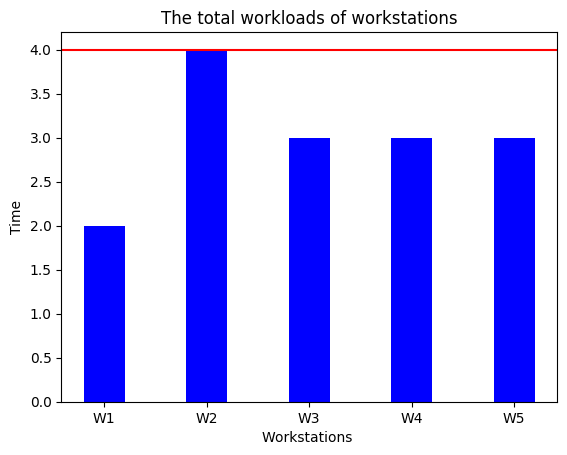

In [19]:
# Plot initial solution
plt = Make_Solution_to_plot(soln_init, WS, tasks, Cycle_time)
plt.show()

### Run the tabu search

In [20]:
sol_best, SI_best=tabu_search(max_itr, soln_init, SI_init, tenure, WS, tasks, Prec_Matrix, Cycle_time)

### Calculate the smoothing index of the final solution 

In [21]:
Smoothing_index(sol_best, WS, tasks, Cycle_time, True)

######## The Smoothing Index value for ['T3', 'T5', 'T1', 'T4', 'T2', 'T6'] solution sequence is: 0.0 ########
######## The number of workstations for ['T3', 'T5', 'T1', 'T4', 'T2', 'T6'] solution sequence is: 5 ########
######## The workloads of workstation for ['T3', 'T5', 'T1', 'T4', 'T2', 'T6'] solution sequence are: [3. 3. 3. 3. 3.] ########


0.0

### Plot the final solution 

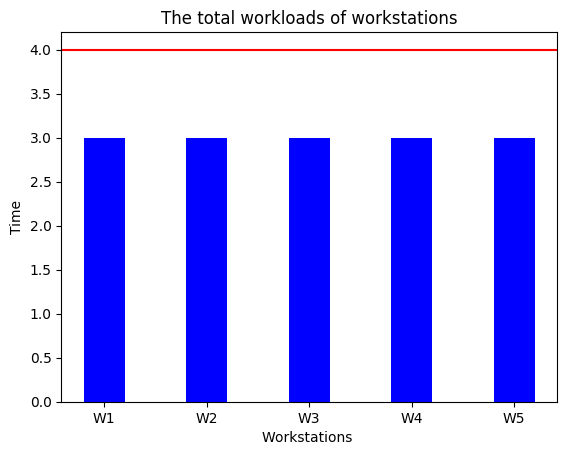

In [22]:
plt = Make_Solution_to_plot(sol_best, WS, tasks, Cycle_time)
plt.show()